# Sales Forecasting Analysis

## Project Overview
This notebook demonstrates a complete workflow for forecasting retail sales using historical transaction data. We will use **Facebook Prophet**, a robust library for time series forecasting, to predict future sales trends.

### Objectives
1.  **Data Loading & Cleaning**: Prepare the raw dataset for analysis.
2.  **Exploratory Data Analysis (EDA)**: Visualize historical sales trends.
3.  **Modeling**: Train a Prophet model on the aggregated sales data.
4.  **Forecasting**: Predict sales for the next 90 days.
5.  **Advanced Insights**: Analyze monthly trends, top products, and seasonality.
6.  **Export**: Save the forecast results for Power BI dashboarding.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
# Custom professional palette (Deep Blue, Teal, Gold, Coral, Purple)
custom_palette = ['#2C3E50', '#18BC9C', '#F39C12', '#E74C3C', '#8E44AD']
sns.set_palette(custom_palette)
sns.set_context('notebook', font_scale=1.2)
%matplotlib inline

c:\Users\Hardeep singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Loading and Cleaning

In [2]:
# Load the dataset
# Using 'ISO-8859-1' encoding to handle special characters common in retail datasets
try:
    df = pd.read_csv('Dataset.csv', encoding='ISO-8859-1')
except UnicodeDecodeError:
    df = pd.read_csv('Dataset.csv', encoding='cp1252')

# Display first few rows
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [3]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [4]:
# Convert ORDERDATE to datetime
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

# Sort by date
df = df.sort_values('ORDERDATE')

# Check date range
print(f"Date Range: {df['ORDERDATE'].min()} to {df['ORDERDATE'].max()}")

Date Range: 2003-01-06 00:00:00 to 2005-05-31 00:00:00


## 2. Exploratory Data Analysis (EDA)
We will aggregate sales by date to understand the overall trend.

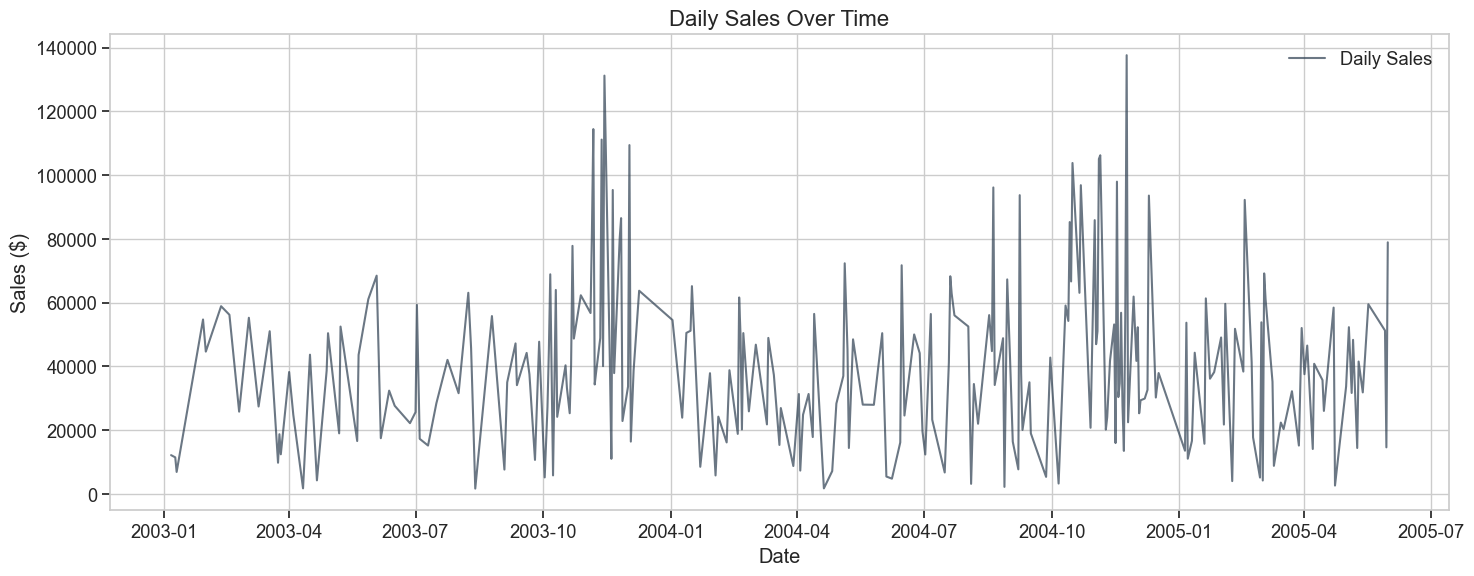

In [5]:
# Aggregate sales by Date
daily_sales = df.groupby('ORDERDATE')['SALES'].sum().reset_index()

# Plot Daily Sales
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['ORDERDATE'], daily_sales['SALES'], label='Daily Sales', color='#2C3E50', alpha=0.7)
plt.title('Daily Sales Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Modeling with Prophet
Prophet requires the input dataframe to have two specific columns:
- `ds`: The datestamp column.
- `y`: The numeric metric to forecast.

In [6]:
# Prepare data for Prophet
prophet_df = daily_sales.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'})

# Initialize Prophet model
# Tuning for better accuracy:
# 1. Multiplicative seasonality (sales grow with trend)
# 2. US Holidays (Retail impact)
# 3. More flexible trend (changepoint_prior_scale)
m = Prophet(seasonality_mode='multiplicative', 
            daily_seasonality=False, 
            yearly_seasonality=True, 
            weekly_seasonality=True,
            changepoint_prior_scale=0.5,
            seasonality_prior_scale=10.0)

# Add US Holidays
m.add_country_holidays(country_name='US')

# Fit the model
m.fit(prophet_df)

15:29:20 - cmdstanpy - INFO - Chain [1] start processing
15:29:20 - cmdstanpy - INFO - Chain [1] done processing


## 4. Forecasting
We will generate a forecast for the next 90 days.

In [7]:
# Create future dataframe for 90 days
future = m.make_future_dataframe(periods=90)

# Predict
forecast = m.predict(future)

# Display forecast head
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
337,2005-08-25,58725.577235,28670.394202,88315.858787
338,2005-08-26,54654.923634,25952.930510,83059.985931
339,2005-08-27,36759.164719,8183.698389,66838.751620
340,2005-08-28,59035.196775,29802.256905,88166.234299
341,2005-08-29,45192.978817,16737.711297,74960.156773


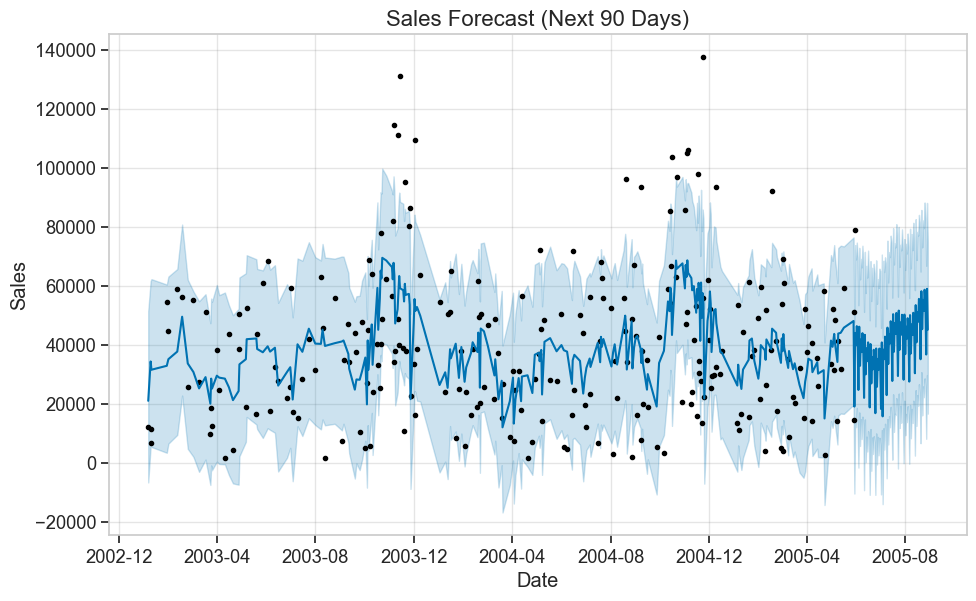

In [8]:
# Visualize the forecast
fig1 = m.plot(forecast)
plt.title('Sales Forecast (Next 90 Days)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

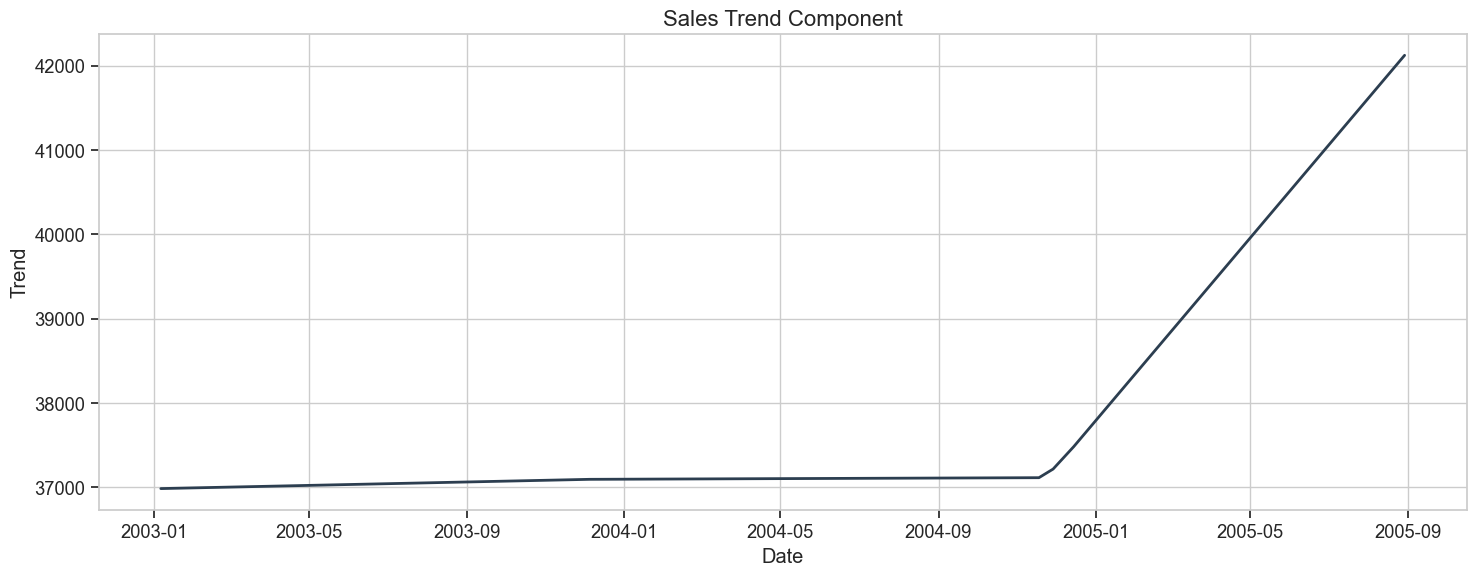

C:\Users\Hardeep singh\AppData\Local\Temp\ipykernel_5292\509940923.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weekly_seasonality, x='day_of_week', y='weekly', palette='viridis')


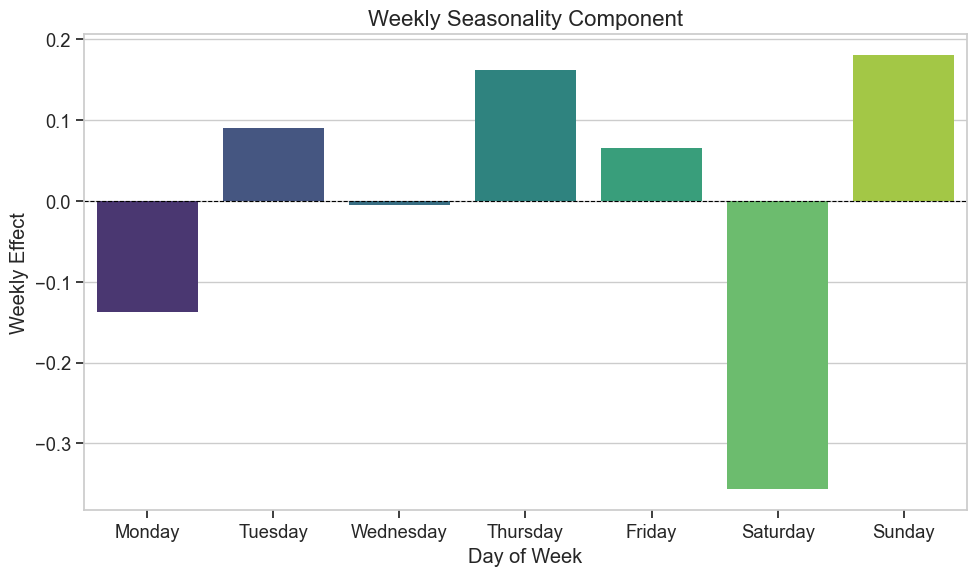

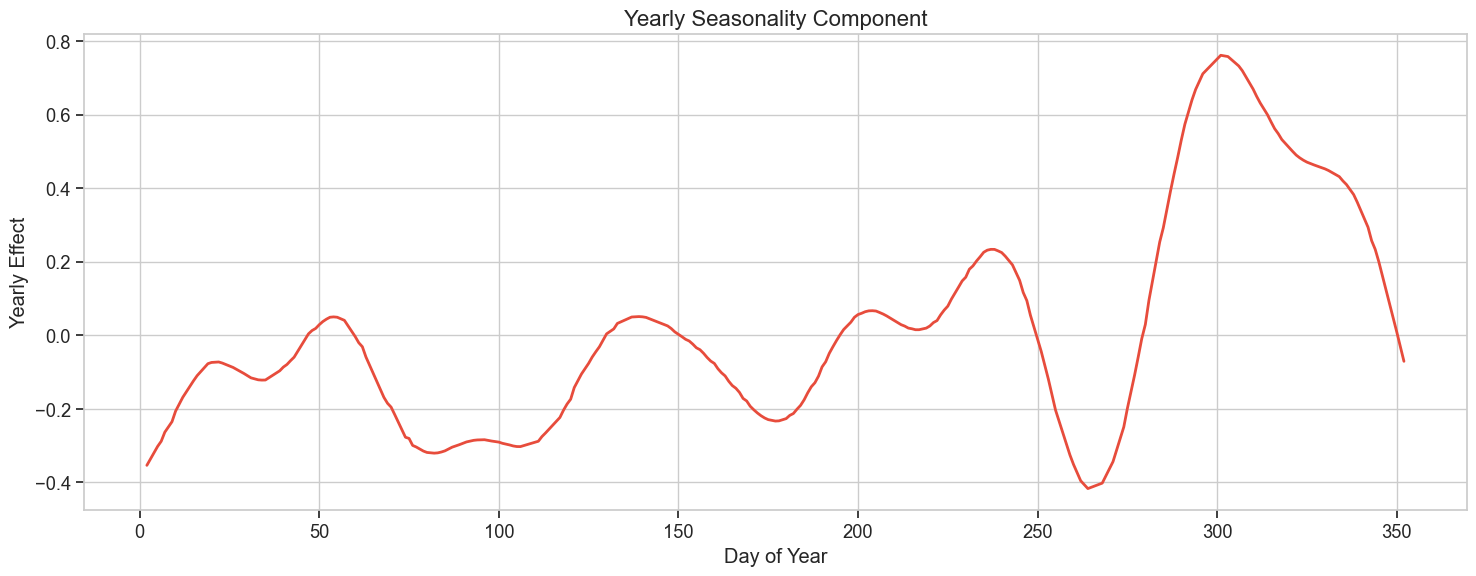

In [9]:
# Visualize Components Custom Plots
# Extract components
forecast['day_of_week'] = forecast['ds'].dt.day_name()
forecast['day_num'] = forecast['ds'].dt.dayofweek

# 1. Trend Component
plt.figure(figsize=(15, 6))
sns.lineplot(data=forecast, x='ds', y='trend', color='#2C3E50', linewidth=2)
plt.title('Sales Trend Component', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Trend')
plt.tight_layout()
plt.show()

# 2. Weekly Seasonality Component
# Group by day of week to get the unique weekly effect
weekly_seasonality = forecast.groupby(['day_num', 'day_of_week'])['weekly'].mean().reset_index().sort_values('day_num')

plt.figure(figsize=(10, 6))
sns.barplot(data=weekly_seasonality, x='day_of_week', y='weekly', palette='viridis')
plt.title('Weekly Seasonality Component', fontsize=16)
plt.xlabel('Day of Week')
plt.ylabel('Weekly Effect')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.tight_layout()
plt.show()

# 3. Yearly Seasonality Component
forecast['day_of_year'] = forecast['ds'].dt.dayofyear
yearly_seasonality = forecast.groupby('day_of_year')['yearly'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(data=yearly_seasonality, x='day_of_year', y='yearly', color='#E74C3C', linewidth=2)
plt.title('Yearly Seasonality Component', fontsize=16)
plt.xlabel('Day of Year')
plt.ylabel('Yearly Effect')
plt.tight_layout()
plt.show()

In [10]:
# Calculate Projected Growth
# Compare the last forecasted value with the value 90 days prior
future_period = 90
last_forecast_value = forecast['yhat'].iloc[-1]
first_forecast_value = forecast['yhat'].iloc[-future_period]
projected_growth = ((last_forecast_value / first_forecast_value) - 1) * 100

print(f"Projected Sales Growth over next {future_period} days: {projected_growth:.2f}%")

Projected Sales Growth over next 90 days: 13.37%


## 5. Advanced Insights for Decision Making
We will derive key business insights to support decision making.

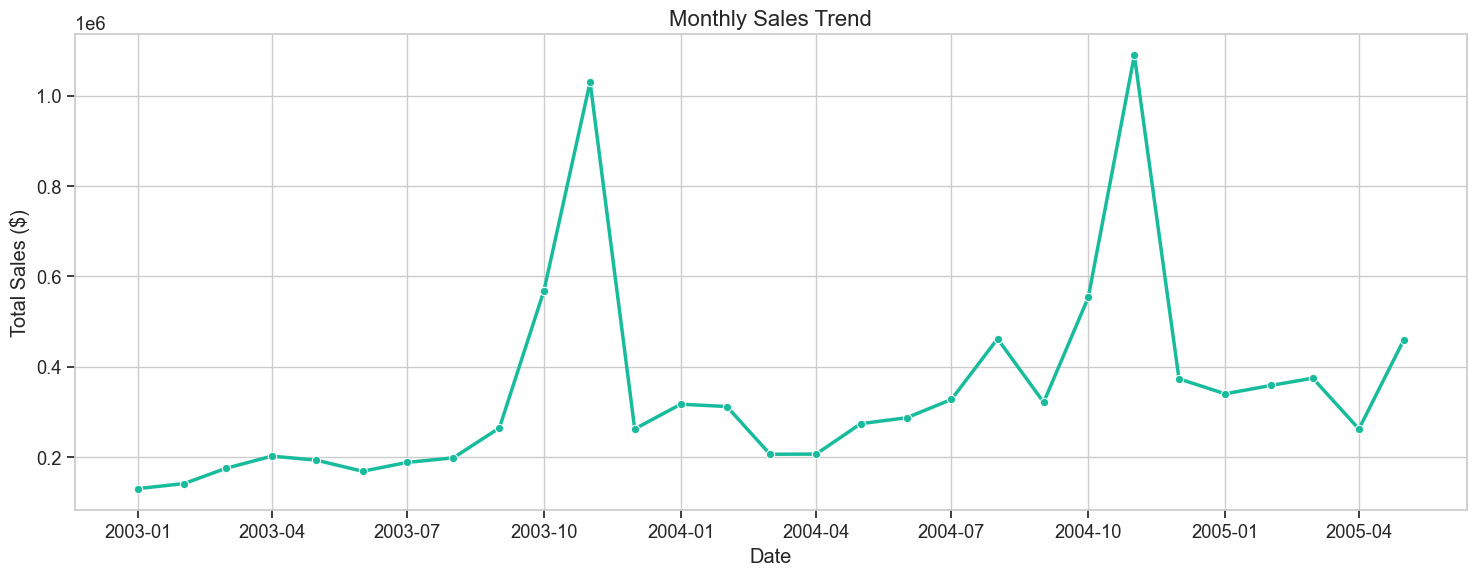

In [11]:
# 1. Monthly & Yearly Trends
df['Year'] = df['ORDERDATE'].dt.year
df['Month'] = df['ORDERDATE'].dt.month

monthly_sales = df.groupby(['Year', 'Month'])['SALES'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(DAY=1))

plt.figure(figsize=(15, 6))
sns.lineplot(data=monthly_sales, x='Date', y='SALES', marker='o', color='#18BC9C', linewidth=2.5)
plt.title('Monthly Sales Trend', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.tight_layout()
plt.show()

C:\Users\Hardeep singh\AppData\Local\Temp\ipykernel_5292\3581615646.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items.index, y=top_items.values, palette='viridis')


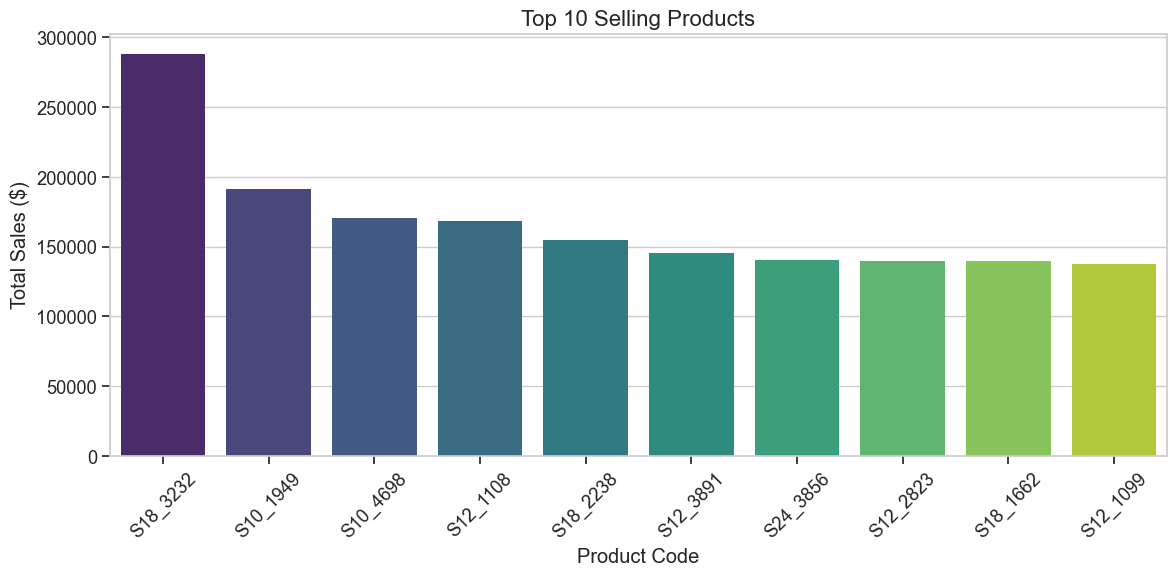

In [12]:
# 2. Top Selling Items
top_items = df.groupby('PRODUCTCODE')['SALES'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_items.index, y=top_items.values, palette='viridis')
plt.title('Top 10 Selling Products', fontsize=16)
plt.ylabel('Total Sales ($)')
plt.xlabel('Product Code')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Hardeep singh\AppData\Local\Temp\ipykernel_5292\14335058.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='SALES', y='PRODUCTLINE', estimator=sum, errorbar=None, palette='mako')


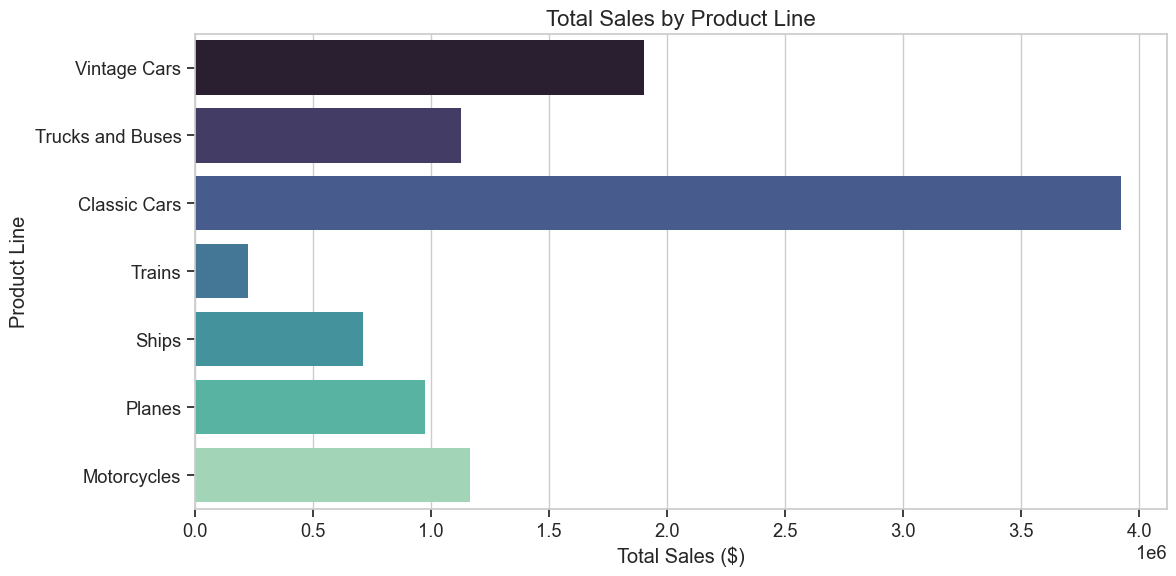

In [13]:
# 3. Sales by Category (Product Line)
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='SALES', y='PRODUCTLINE', estimator=sum, errorbar=None, palette='mako')
plt.title('Total Sales by Product Line', fontsize=16)
plt.xlabel('Total Sales ($)')
plt.ylabel('Product Line')
plt.tight_layout()
plt.show()

C:\Users\Hardeep singh\AppData\Local\Temp\ipykernel_5292\2237062048.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='magma')


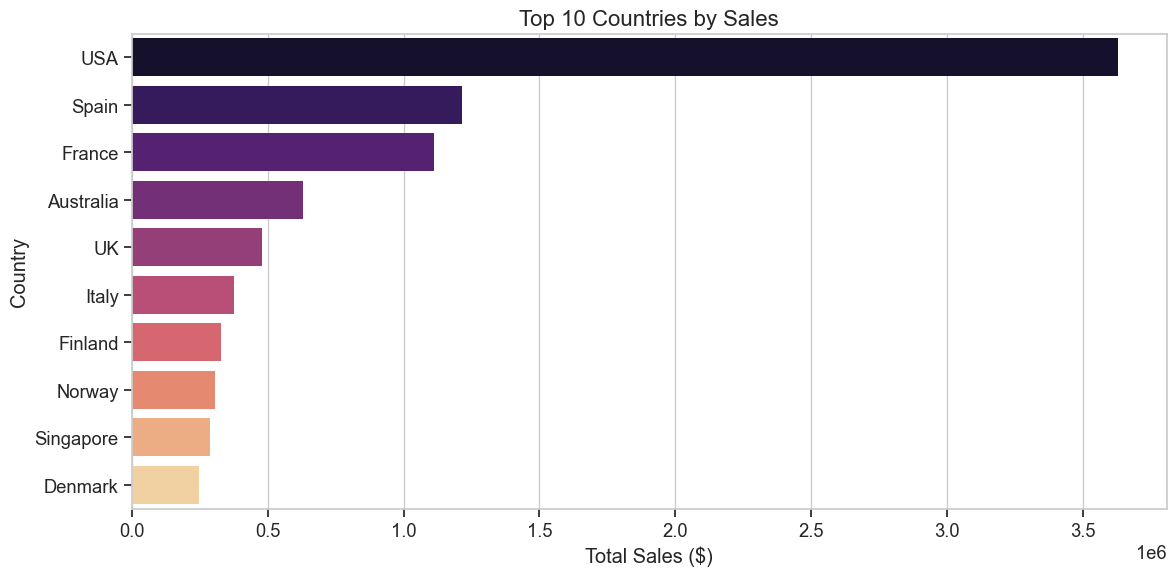

In [14]:
# 4. Sales by Region (Country)
top_countries = df.groupby('COUNTRY')['SALES'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='magma')
plt.title('Top 10 Countries by Sales', fontsize=16)
plt.xlabel('Total Sales ($)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

C:\Users\Hardeep singh\AppData\Local\Temp\ipykernel_5292\3984004933.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_monthly_sales.index, y=avg_monthly_sales.values, palette='coolwarm')


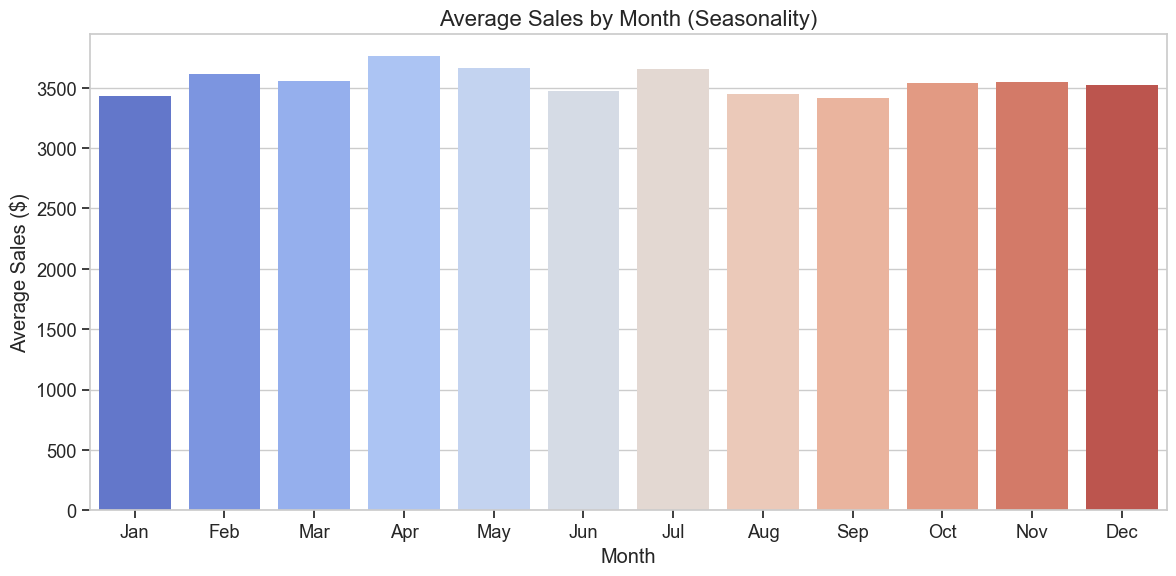

In [15]:
# 5. Seasonality Analysis (Best/Worst Months)
avg_monthly_sales = df.groupby('Month')['SALES'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_monthly_sales.index, y=avg_monthly_sales.values, palette='coolwarm')
plt.title('Average Sales by Month (Seasonality)', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Average Sales ($)')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

## 6. Export Results
We will export the forecast data to a CSV file. This file can be directly imported into Power BI to build the dashboard.

In [16]:
# Prepare export dataframe
# We'll merge the actuals with the forecast for a complete view
export_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

# Merge with actuals
export_df = export_df.merge(prophet_df, on='ds', how='left')
export_df.rename(columns={'ds': 'Date', 'y': 'Actual_Sales', 'yhat': 'Predicted_Sales', 'yhat_lower': 'Lower_Bound', 'yhat_upper': 'Upper_Bound'}, inplace=True)

# Fill NaN in Actual_Sales with 0 or keep as NaN depending on preference (keeping as NaN for future dates)

# Save to CSV
export_df.to_csv('forecast_results_full.csv', index=False)
print("Exported successfully to 'forecast_results_full.csv'")

Exported successfully to 'forecast_results_full.csv'
